# Welcome to the Lab 🥼🧪
## Which metros have the highest concentration of investor ownership? 

In this notebook, we are going to create a table of the last 12 months of the total share of all homes owned by investors for the top 100 markets based on
total number of housing stock. 

Welcome to the Lab - LFG

**Note** This notebook will work with any of the 70k+ markets supported by the Parcl Labs API.

As a reminder, you can get your Parcl Labs API key [here](https://dashboard.parcllabs.com/signup) to follow along. 

To run this immediately, you can use Google Colab. Remember, you must set your `PARCL_LABS_API_KEY` as as secret. See this [guide](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75) for more information.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ParclLabs/parcllabs-examples/blob/main/python/table_of_investor_concentration.ipynb)

We will be creating this table: 
![Chart](assets/all_homes_owned_by_investors.png)

In [1]:
# Environment setup
import os
import sys
import subprocess
from datetime import datetime

# Collab setup from one click above
if "google.colab" in sys.modules:
    from google.colab import userdata
    cmd = "pip install --upgrade parcllabs plotly kaleido"
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    api_key = userdata.get('PARCL_LABS_API_KEY')
else:
    api_key = os.getenv('PARCL_LABS_API_KEY')

In [2]:
import parcllabs
import pandas as pd
import plotly.express as px
from parcllabs import ParclLabsClient

print(f"Parcl Labs Version: {parcllabs.__version__}")

Parcl Labs Version: 0.1.16


In [3]:
client = ParclLabsClient(api_key=api_key)

In [4]:
# lets get all metros in the country

metros = client.search_markets.retrieve(
    location_type='CBSA',
    as_dataframe=True,
    params={
        'limit': 1000
    }
)

In [9]:
# get the ids
metro_ids = metros['parcl_id'].tolist()

In [10]:
# get most recent housing stock for all metros
housing_stock = client.market_metrics_housing_stock.retrieve_many(
    parcl_ids=metro_ids,
    params={
        'limit': 1 # let's get the most recent stock
    },
    as_dataframe=True # make life easy on ourselves
)

In [14]:
housing_stock.head()

,date,single_family,condo,townhouse,other,all_properties,parcl_id
0,2024-03-01,12739,372,275,4547,17933,2899848
0,2024-03-01,24476,1495,47,14332,40350,2899849
0,2024-03-01,51079,2680,266,17907,71932,2899850
0,2024-03-01,10794,164,15,1991,12964,2899851
0,2024-03-01,33835,2111,20,8067,44033,2899852


In [56]:
top_100 = housing_stock.sort_values('all_properties', ascending=False).head(100)
metros.head()

,parcl_id,country,geoid,state_fips_code,name,state_abbreviation,region,location_type
0,2899848,USA,10100,None,"Aberdeen, Sd",None,None,CBSA
1,2899849,USA,10140,None,"Aberdeen, Wa",None,None,CBSA
2,2899850,USA,10180,None,"Abilene, Tx",None,None,CBSA
3,2899851,USA,10220,None,"Ada, Ok",None,None,CBSA
4,2899852,USA,10300,None,"Adrian, Mi",None,None,CBSA


In [67]:
# investor ownership for these top 100 markets
investor_ownership = client.investor_metrics_housing_stock_ownership.retrieve_many(
    parcl_ids=top_100['parcl_id'].tolist(),
    params={
        'limit': 12, # get last 6 mo's 
    },
    as_dataframe=True
)

In [70]:
out = pd.merge(metros[['parcl_id', 'name']], investor_ownership[['parcl_id',  'date', 'pct_ownership']], on='parcl_id')
out = out.drop('parcl_id', axis=1)
out['pct_ownership'] = out['pct_ownership']/100
out.head()

,name,date,pct_ownership
0,"Akron, Oh",2024-03-01,0.0956
1,"Akron, Oh",2024-02-01,0.0956
2,"Akron, Oh",2024-01-01,0.0956
3,"Akron, Oh",2023-12-01,0.0953
4,"Akron, Oh",2023-11-01,0.0952


In [123]:
def format_names(nme):
    state = nme.split(',')[-1].strip()
    metro = nme.split(',')[0].split('-')[0].strip()
    metro = metro.split('/')[0].strip()
    return metro.replace('Colorado', 'Co')
    # return f"{metro}, {state}"

out['name'] = out['name'].apply(lambda x: format_names(x))

charting_data = out.pivot_table(values='pct_ownership', index='name', columns='date')
charting_data.index

Index(['Akron', 'Albany', 'Albuquerque', 'Allentown', 'Atlanta', 'Augusta',
       'Austin', 'Bakersfield', 'Baltimore', 'Baton Rouge', 'Birmingham',
       'Boise City', 'Boston', 'Bridgeport', 'Buffalo', 'Cape Coral',
       'Charleston', 'Charlotte', 'Chattanooga', 'Chicago', 'Cincinnati',
       'Cleveland', 'Co Springs', 'Columbia', 'Columbus', 'Dallas', 'Dayton',
       'Deltona', 'Denver', 'Des Moines', 'Detroit', 'Durham', 'El Paso',
       'Fresno', 'Grand Rapids', 'Greensboro', 'Greenville', 'Hartford',
       'Houston', 'Indianapolis', 'Jacksonville', 'Kansas City', 'Knoxville',
       'Lakeland', 'Las Vegas', 'Little Rock', 'Los Angeles', 'Louisville',
       'Madison', 'Mcallen', 'Memphis', 'Miami', 'Milwaukee', 'Minneapolis',
       'Myrtle Beach', 'Naples', 'Nashville', 'New Haven', 'New Orleans',
       'New York', 'North Port', 'Oklahoma City', 'Omaha', 'Orlando', 'Oxnard',
       'Palm Bay', 'Pensacola', 'Philadelphia', 'Phoenix', 'Pittsburgh',
       'Port St. Lucie'

In [127]:
charting_data = charting_data.sort_values('2024-03-01', ascending=False)

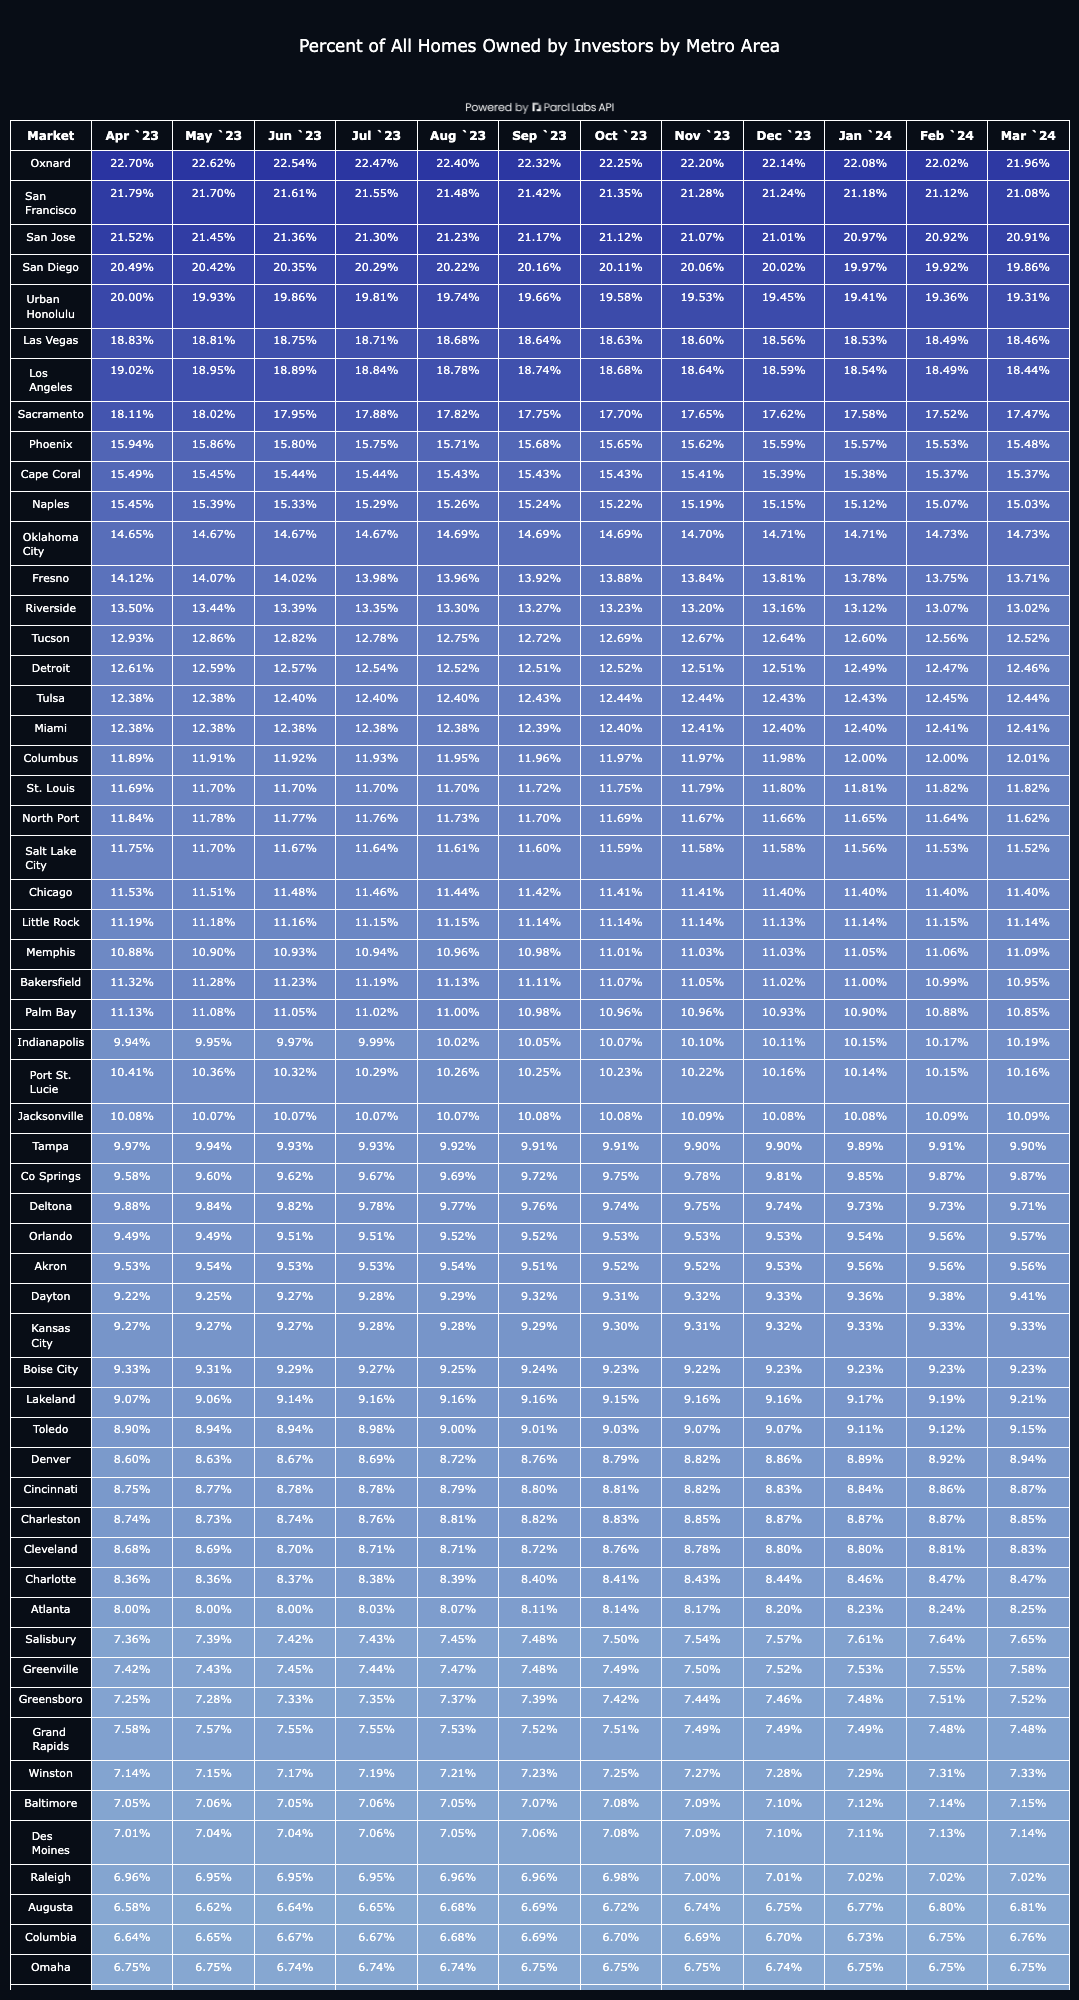

In [132]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Assuming charting_data is defined
# Assume 'charting_data' is already in your workspace with correct data

# Function to apply diverging color scheme
def color_scale(value):
    # Normalize value within the range [0, 0.3]
    normalized = min(max(value / 0.3, 0), 1)
    # Convert to a color in the blue scale
    # Light blue (e.g., #ADD8E6) to dark blue (e.g., #00008B)
    r = int((173 + (0 - 173) * normalized))  # R component ranges from 173 to 0
    g = int((216 + (0 - 216) * normalized))  # G component ranges from 216 to 0
    b = int((230 + (139 - 230) * normalized))  # B component ranges from 230 to 139
    return f'rgb({r},{g},{b})'

# Date formatting function for headers
def format_date(date):
    date = datetime.strptime(date, '%Y-%m-%d')
    return date.strftime('%b `' + date.strftime('%y'))  # Formats like "Jan '23"

dates = charting_data.columns.tolist()

# labs_logo_dict setup
labs_logo_lookup = {
    'blue': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api.png',
    'white': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api-logo-white.png'
}

labs_logo_dict = dict(
    source=labs_logo_lookup['white'],
    xref="paper",
    yref="paper",
    x=0.5,  # Centering the logo below the title
    y=1,  # Adjust this value to position the logo just below the title
    sizex=0.15,
    sizey=0.1,
    xanchor="center",
    yanchor="bottom"
)

# Creating the table
fig = go.Figure(
    data=[go.Table(
        header=dict(
            values=['<b>Market</b>'] + [f"<b>{format_date(date)}</b>" for date in dates],
            fill_color='#080D16',
            font=dict(color='#FFFFFF', size=12),
            align='center',
            height=30
        ),
        cells=dict(
            values=[[f"{name}" for name in charting_data.index]] + 
                   [charting_data[date].apply(lambda x: f"{x:.2%}") for date in dates],
            fill=dict(
                color=[
                    ['#080D16']*len(charting_data.index)] +  # Keep Market column unicolor
                    [[color_scale(charting_data.at[market, date]) for market in charting_data.index] for date in dates]
            ),
            font=dict(
                color='#FFFFFF',
                size=[11 if i == 0 else 11 for i in range(len(dates) + 1)]  # Increase font size for 'Market' column
            ),
            align='center',
            height=30
        ))
])

# Add logo below the title
fig.add_layout_image(labs_logo_dict)

# Adjust table layout size and title
fig.update_layout(
    title={
        'text': 'Percent of All Homes Owned by Investors by Metro Area',
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    title_font_color='#FFFFFF',
    width=1400,  # Adjust width as needed
    height=2000,
    paper_bgcolor='#080D16',
    margin=dict(l=10, r=10, t=120, b=10)  # Increased top margin to accommodate the logo
)

# Show the figure
fig.show()
